In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.cluster import OPTICS

from utils.denoise import *
from utils.data_io import *
from utils.plot import get_plt

In [359]:
path_str = "processed_ATL03_20221230185202_01561807_006_02_gt3r_cut.csv"
data_path = Path(path_str)

df = None
with open(data_path, 'r') as f:
    df = pd.read_csv(f)
    
print(df.columns)

df["point_type"] = PointType.NotClassified.value
print(df["point_type"].dtypes)

Index(['Unnamed: 0', 'Time (sec)', 'Delta Time (sec)', 'Segment ID', 'GT Num',
       'Beam Num', 'Beam Type', 'Latitude (deg)', 'Longitude (deg)',
       'UTM Easting (m)', 'UTM Northing (m)', 'UTM Zone', 'UTM Hemisphere',
       'Cross-Track (m)', 'Along-Track (m)', 'Height (m HAE)',
       'Height (m MSL)', 'Classification', 'Signal Confidence',
       'Solar Elevation (deg)'],
      dtype='object')
int64


In [360]:
sea_level, water_surface = get_sea_level(df, n_sigmas=0.8)

print(f"sea_level: {sea_level}, limit: {water_surface}")

df.loc[
    (df["Height (m MSL)"] > water_surface[0])
    & (df["Height (m MSL)"] < water_surface[1]),
    "point_type",
] = PointType.WaterSurface.value

df.loc[(df["Height (m MSL)"] >= water_surface[1]), "point_type"] = PointType.Noise.value

sea_level: 0.8073118184511227, limit: (np.float64(0.5446190736047178), np.float64(1.0700045632975275))


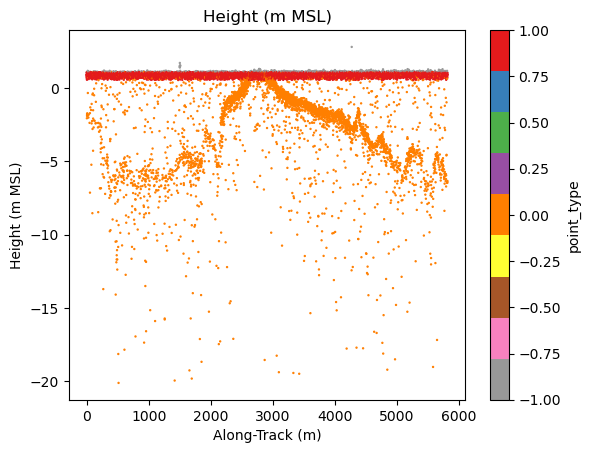

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Height (m MSL)'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [361]:
# 筛选出高度低于水面的数据
underwater_mask = df["Height (m MSL)"] < water_surface[0]

# 获取需要调整高度的数据列
under_water_point = df.loc[underwater_mask, "Height (m MSL)"]

# 调整高度
real_depth = under_water_point.apply(get_real_depth, args=(sea_level,))

# 将调整后的高度赋值回原数据框
df.loc[underwater_mask, "Height (m MSL)"] = sea_level - real_depth

get_plt(df)

In [362]:
# optics_clustering_denoise的效果更好
under_water_point = df.loc[underwater_mask].copy()
noise_points = optics_clustering_denoise(under_water_points=under_water_point)
original_indices = under_water_point.index[noise_points]
df.loc[original_indices, "point_type"] = PointType.Noise.value

land_points = np.logical_not(noise_points)
original_indices = under_water_point.index[land_points]
df.loc[original_indices, "point_type"] = PointType.LandSurface.value

# get_plt(df)
# get_plt(df.loc[underwater_mask])

# under_water_point = df.loc[underwater_mask].copy()
# noise_points = dbscan_denoise(under_water_points=under_water_point, eps=8, min_samples=10)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)

# under_water_point = df.loc[underwater_mask].copy()
# noise_points = adaptive_elliptical_denoise(under_water_points=under_water_point,k=3,alpha=0.1)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)

# under_water_point = df.loc[underwater_mask].copy()
# noise_points = adaptive_optics_denoise(under_water_point, eps=1)
# original_indices = under_water_point.index[noise_points]
# df.loc[original_indices, "point_type"] = PointType.Noise.value
# get_plt(df)
# get_plt(df.loc[underwater_mask])

样本数量：4137
类型数量：1
噪声点数量：1457
噪声点比例：0.35218757553782937
样本数量：4137
有效点数量：2680
噪声点数量：1457
有效点比例：0.6478124244621707
噪声点比例：0.35218757553782937


In [363]:
df = df.loc[df["point_type"] != PointType.Noise.value]

区块 0.0 可能是陆地
区块 52.0 可能是陆地
区块 55.0 可能是陆地
区块 56.0 可能是陆地
区块 57.0 可能是陆地


C:\Users\natsuu\AppData\Local\Temp\ipykernel_206876\689742807.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["block"] = df[ICESAT2Properties.AlongTrack.value] // 50


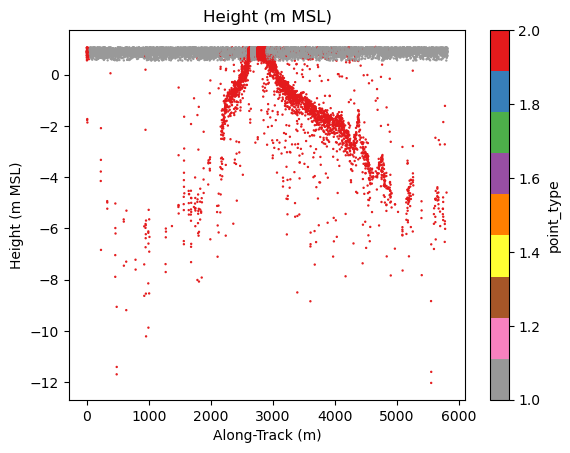

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Height (m MSL)'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [364]:
from utils.property import ICESAT2Properties

df["block"] = df[ICESAT2Properties.AlongTrack.value] // 50
unique_blocks = df["block"].unique()
for i in unique_blocks:
    above_water_points_num = df[(df["block"] == i) & (df["Height (m MSL)"] >= water_surface[0])].shape[0]
    under_water_points_num = df[(df["block"] == i) & (df["Height (m MSL)"] < water_surface[0])].shape[0]
    min_under_water_point = df[df["block"] == i]["Height (m MSL)"].min()
    if  1 < under_water_points_num and under_water_points_num < 25 and min_under_water_point > -3:
        print(f"区块 {i} 可能是陆地")
        df.loc[(df["block"] == i) & (df["Height (m MSL)"] >= water_surface[0]), "point_type"] = PointType.LandSurface.value

get_plt(df)
        

In [366]:
save_csv(df, data_path.stem, "denoise", backup=True, overwrite=True)

Save processed_ATL03_20221230185202_01561807_006_02_gt3r_cut_denoise.csv successfully!
try to backup processed_ATL03_20221230185202_01561807_006_02_gt3r_cut_denoise.csv to e:\Documents\课程学习\GraduationProject\program\log
Backup processed_ATL03_20221230185202_01561807_006_02_gt3r_cut_denoise.csv to e:\Documents\课程学习\GraduationProject\program\log\processed_ATL03_20221230185202_01561807_006_02_gt3r_cut_denoise_20250525065416.csv


True